# MLM + WaveGAN

In [ ]:
model.load_state_dict(states["model"])

model = cls.build_model(args=args)

from espnet2.tasks.mlm import MLMTask

MLMTask.build_model_from_file(config_file='/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/mlm_train_mlm_raw_en_bpe5000/config.yaml',
                             model_file='/mnt/home/v_baihe/projects/espnet/egs2/an4/asr1/exp/mlm_train_mlm_raw_en_bpe5000/valid.loss.ave_10best.pth')

In [1]:
from espnet2.tasks.tts import TTSTask
from parallel_wavegan.utils import download_pretrained_model
from pathlib import Path
from espnet2.train.dataset import ESPnetDataset
from espnet2.tts.feats_extract.log_mel_fbank import LogMelFbank

vocoder_tag = "parallel_wavegan/libritts_parallel_wavegan.v1".replace("parallel_wavegan/", "")
vocoder_file = download_pretrained_model(vocoder_tag)
vocoder_config = Path(vocoder_file).parent / "config.yml"
    
    
vocoder = TTSTask.build_vocoder_from_file(
                vocoder_config, vocoder_file, None, 'cpu'
            )

In [13]:
import torch
import IPython.display as ipd

In [36]:
iter_options = torch.load('/mnt/home/v_baihe/iter_options.pt')
dataset = ESPnetDataset(
            iter_options.data_path_and_name_and_type,
            float_dtype='float32',
            preprocess=iter_options.preprocess_fn,
            max_cache_size=iter_options.max_cache_size,
            max_cache_fd=iter_options.max_cache_fd,
        )

In [38]:
wav_org, file_name = dataset[1][1]['speech'], '/mnt/home/v_baihe/data/feat_dir/toy_librilight/dump/raw/train_nodev/data/format.1/data_wav/'+dataset[1][0]+'.flac'

In [47]:
import soundfile
wav_org, rate = soundfile.read(
                "/mnt/home/v_baihe/data/LibriTTS/train-clean-100/103/1241/103_1241_000000_000001.wav", always_2d=False
            )

In [58]:
feats_extract =  LogMelFbank(fs=24000, n_fft=2048, win_length=1200,hop_length=300)

In [59]:
mel, _ = feats_extract(torch.tensor(wav_org).float().unsqueeze(0), torch.tensor([len(wav_org)]))

In [60]:
input_feat = mel.squeeze().cpu()
wav = vocoder(input_feat)

In [61]:
ipd.Audio(torch.tensor(wav_org).float().data.cpu().numpy(), rate=24000)

In [62]:
ipd.Audio(wav.data.cpu().numpy(), rate=24000)

# Baseline （MFA+Tacotron2+Wavglow） 

In [2]:
import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import torch
from denoiser import Denoiser

waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/home/v_baihe/anaconda3/envs/espnet2/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has change

In [1]:
mel = torch.load('/mnt/home/v_baihe/feature.pt')[:,:200,:].cuda().half()
audio_mel = waveglow.infer(torch.transpose(mel, 1,2), sigma=0.666)

NameError: name 'torch' is not defined

In [9]:
ipd.Audio(audio_mel[0].data.cpu().numpy(), rate=22050)

## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

ModuleNotFoundError: No module named 'tensorflow'

In [50]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [ ]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [9]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [12]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/mnt/home/v_baihe/anaconda3/envs/tacotron/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/home/v_baihe/anaconda3/envs/tacotron/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/mnt/home/v_baihe/anaconda3/envs/tacotron/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has cha

#### Prepare text input

In [13]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

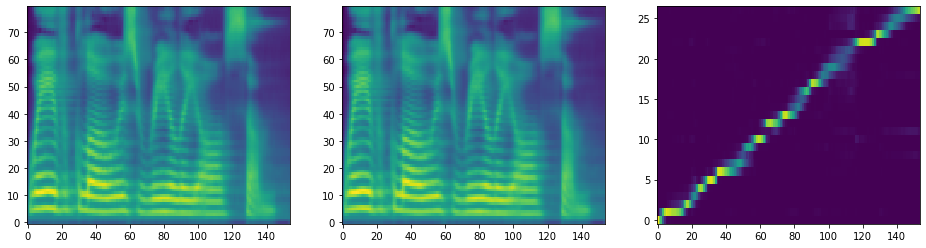

In [14]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [23]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [16]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [176]:
from data_utils import TextMelLoader
import math
from utils import load_wav_to_torch, load_filepaths_and_text
import tgt
hparams = create_hparams()
hparams.sampling_rate = 22050

In [32]:
mel_loader = TextMelLoader("filelists/ljs_audio_text_val_filelist.txt",hparams)

In [77]:
audiopath_and_text = mel_loader.audiopaths_and_text[0]

In [97]:
def get_audio_pairs(audiopath_and_text):
    text, mel = mel_loader.get_mel_text_pair(audiopath_and_text)
#     fig, axes = plt.subplots(1, 1, figsize=(16, 4))
#     axes.imshow(mel.float().data.cpu().numpy(), aspect='auto', origin='bottom', 
#                    interpolation='none')
#     print(mel.shape)
    with torch.no_grad():
        audio_mel = waveglow.infer(mel.unsqueeze(0).cuda().half(), sigma=0.666)
    audio_ori,sampling_rate = load_wav_to_torch(audiopath_and_text[0])
    return audio_mel, audio_ori

torch.Size([80, 476])


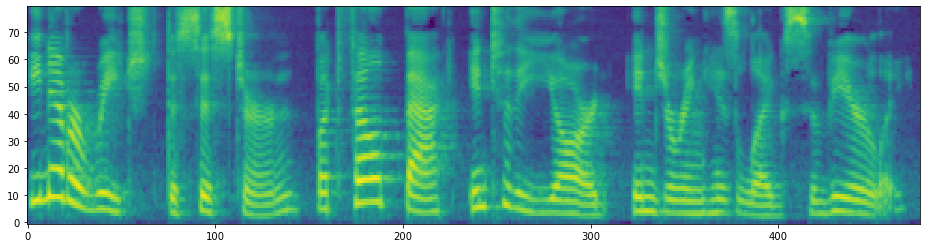

In [113]:
audio_mel, audio_ori = get_audio_pairs(mel_loader.audiopaths_and_text[0])

In [114]:
ipd.Audio(audio_ori.data.cpu().numpy(), rate=hparams.sampling_rate)

In [115]:
ipd.Audio(audio_mel[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import math
import tgt
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from data_utils import TextMelLoader
from utils import load_wav_to_torch, load_filepaths_and_text
hparams = create_hparams()
hparams.sampling_rate = 22050

In [226]:
def get_new_spec(text):
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    return mel_outputs_postnet

In [228]:
def get_time_span_to_edit(text_span_to_change, old_text, tgt_file):
    def get_alignment(tier, span, full_text):
        start_time = 0
        end_time = 0
        discard_part_left = full_text[:span[0]]
        discard_part_right = full_text[span[1]:]
        target_text = full_text[span[0]:span[1]]
        for t in tier._objects:
            s, e, p = t.start_time, t.end_time, t.text
            if not p:
                continue
            if discard_part_left and p == discard_part_left[:len(p)]:
                discard_part_left = discard_part_left[len(p):].strip()
            elif p == target_text[:len(p)]:
                target_text = target_text[len(p):].strip()
                if start_time==0:
                    start_time = s
                end_time = e
            else:
                return start_time, end_time
    textgrid = tgt.io.read_textgrid(tgt_file)
    start, end = get_alignment(
            textgrid.get_tier_by_name("words"), text_span_to_change, old_text.lower()
        )
    return (start, end)

In [229]:
def post_editing(audiopath_and_text, time_span, new_spec):
    audio_span = (time_span[0]*hparams.sampling_rate, time_span[1]*hparams.sampling_rate)
    mel_span = (math.floor(audio_span[0]/hparams.hop_length),math.ceil(audio_span[1]/hparams.hop_length) )
    text, mel = mel_loader.get_mel_text_pair(audiopath_and_text)
    mel = mel.unsqueeze(0).cuda().half()
    mel = torch.cat([mel[:,:,:mel_span[0]],new_spec,mel[:,:,mel_span[1]:]],-1)
    with torch.no_grad():
        audio_mel = waveglow.infer(mel, sigma=0.666)
    audio_ori,sampling_rate = load_wav_to_torch(audiopath_and_text[0])
    return audio_mel, audio_ori

In [241]:
text_span_to_change =(9,16)
text_tobe_replaced = 'reached'
text_target='opened'

In [242]:
mel_loader = TextMelLoader("filelists/ljs_audio_text_val_filelist.txt",hparams)
audiopath, text = mel_loader.audiopaths_and_text[0]
print(text)

textgrid_path = audiopath.replace('wavs', 'TextGrid').replace('.wav','.TextGrid')

span = get_time_span_to_edit(text_span_to_change, text, textgrid_path)

new_mel_span = get_new_spec(text_target)

audio_mel, audio_ori = post_editing((audiopath, text),span, new_mel_span)

'He never reached the cistern, but fell back into the yard, injuring his legs severely.'

In [247]:
ipd.Audio(audio_ori.data.cpu().numpy(), rate=hparams.sampling_rate)

In [248]:
ipd.Audio(audio_mel[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [249]:
hparams

HParams([('attention_dim', 128), ('attention_location_kernel_size', 31), ('attention_location_n_filters', 32), ('attention_rnn_dim', 1024), ('batch_size', 64), ('cudnn_benchmark', False), ('cudnn_enabled', True), ('decoder_rnn_dim', 1024), ('dist_backend', 'nccl'), ('dist_url', 'tcp://localhost:54321'), ('distributed_run', False), ('dynamic_loss_scaling', True), ('encoder_embedding_dim', 512), ('encoder_kernel_size', 5), ('encoder_n_convolutions', 3), ('epochs', 500), ('filter_length', 1024), ('fp16_run', False), ('gate_threshold', 0.5), ('grad_clip_thresh', 1.0), ('hop_length', 256), ('ignore_layers', ['embedding.weight']), ('iters_per_checkpoint', 1000), ('learning_rate', 0.001), ('load_mel_from_disk', False), ('mask_padding', True), ('max_decoder_steps', 1000), ('max_wav_value', 32768.0), ('mel_fmax', 8000.0), ('mel_fmin', 0.0), ('n_frames_per_step', 1), ('n_mel_channels', 80), ('n_symbols', 148), ('p_attention_dropout', 0.1), ('p_decoder_dropout', 0.1), ('postnet_embedding_dim', 51